Write a program in python to implement Gaussian Processes for classification. Follow the below instructions.

1. Generate two classes of data with the same population size (N1=N2=50), sigma = 0.1, mean1 = [2,2], mean2= [3,3].

In [219]:
def ker(theta0, theta1, theta2, theta3, xi, xj):
    # Inputs: xi and xj are type int
    # Returns output of type int 
    return theta0*np.exp((-theta1/2)*np.power(np.linalg.norm(xi-xj), 2)) + theta2 + theta3*np.dot(np.transpose(xi),xj)

def sigmoid(x):
    return 1/(1+ np.exp(-x))

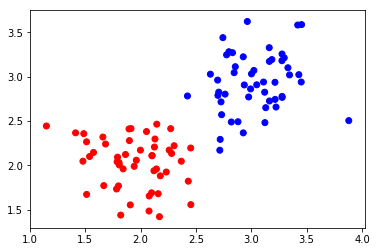

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Datapoints for both classes
N1 = 50
N2 = 50
# K is the number of classes
K = 2
sigma = 0.1
N = N1 + N2

mean = (2,2)
# Covariance matrix with sigma as diagonal
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
# create list of 'red' for the X1 points
c1 = ['red'] * len(X1)

mean = (3,3)
# Covariance matrix with sigma as diagonal
cov = [[sigma, 0], [0,sigma]]
X2 = np.random.multivariate_normal(mean,cov,N2)
c2 = ['blue']*len(X2)

# All X datapoints - first 50 are red, next 50 are blue
X = np.concatenate((X1,X2))
color = np.concatenate((c1,c2))

# T here is Nx1 - one for class 1, 0 otherwise
T = 0*np.ones([len(X)])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n] = 0
    if(n>N1 and n<len(X1)+len(X2)):
        T[n] = 1
T = T.astype(int)

# In this case, we want X to be of dimensions 
# ones = np.array([np.ones(X.shape[0])])
# X = np.concatenate((X, np.transpose(ones)), axis = 1)

plt.scatter(X[:,0], X[:,1], marker = 'o', c = color)
plt.show()

2. Write code of Gaussian Processes to classify the two clusters.
3. Use the kernel written on the textbook (page 307, Eq.(6.63)). As for its parameters, initially you set them (1.0, 4.0, 1.0, 2.0).

In [221]:
def GP_Classification(theta0, theta1, theta2, theta3):  
    # Training stage: Find Cn, a_n mean and Wn

    # 1. Find Cn, which is the matrix with each term being k(x_i, x_j).
    # C does not change anymore after this!

    # Set noise v so that C is positive definite
    v = 1
    # Create matrix C
    C_n = np.identity(N)
    for i in range(N):
        for j in range(N):
            C_n[i,j] = ker(theta0, theta1, theta2 , theta3, X[i], X[j])
    C_n = C_n + v*np.identity(N)        

    # 2. Initialise a_n and W_n
    a_0 = np.random.random_sample((N,))
    W_n = np.identity(N)
    for i in range(N):
        W_n[i,i] = sigmoid(a_0[i])*(1-sigmoid(a_0[i]))

    # 3. Iterate until a_n converges
    a_old = a_0
    temp = a_0
    # Put a_new > 1 to enter the loop
    a_new = 10
    n = 0

    while(np.linalg.norm(a_new - temp) > 0.00001):
        n+= 1
        # Update sigbar
        sigbar = sigmoid(a_old)
        # Find a_new with updated sigbar
        a_new = a_old + np.dot( np.linalg.inv( np.linalg.inv(C_n) + W_n ),
                                (T - sigbar - np.dot(np.linalg.inv(C_n),(a_old))))
        # Update W_n for next a_new
        for i in range(N):
            W_n[i,i] = sigmoid(a_new[i])*(1-sigmoid(a_new[i]))
        # Save a_old
        temp = a_old
        # Update a_new
        a_old = a_new

    a_mean = a_old

    xaxis = np.arange(0, 6, 0.2)
    yaxis = np.arange(0, 6, 0.2)
    prob = np.zeros((len(xaxis),len(yaxis)))

    for i in range(len(xaxis)):
        for j in range(len(yaxis)):
            # Set x_star
            x_star = np.array([xaxis[i],yaxis[j]]) 
            # Initialise k_star
            k_star = np.zeros(N)
            for p in range(N):              
                k_star[p] = ker(theta0, theta1 , theta2 , theta3 , np.array(X[p]), x_star)
            c_star = ker(theta0, theta1 , theta2 , theta3, x_star, x_star) + v
            u_star = np.transpose(k_star).dot(np.linalg.inv(C_n)).dot(a_mean)
            s_star = c_star - np.transpose(k_star).dot(np.linalg.inv(np.linalg.inv(W_n) + C_n)).dot(k_star)    
            prob[i, j] = sigmoid(u_star/ (1 + np.pi*(s_star**2)/2 )**(0.5))

    plt.scatter(X[:,0], X[:,1], marker = 'o', c = color)
    plt.imshow(prob, interpolation = 'bilinear', origin = 'lower', extent = [0,6,0,6], cmap = plt.cm.jet)

4. Draw the probability map, similar to:

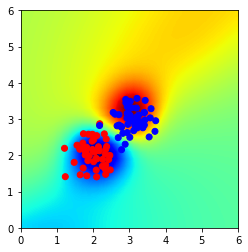

In [213]:
GP_Classification(1,4,1,2)

5. Change the kernel parameters to (1.0, 0.25, 0, 0) to obtain:


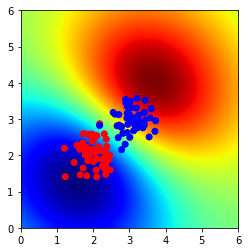

In [214]:
GP_Classification(1,0.25,0,0)

6. Discuss why the new parameters generate a less precise probability map.


Since $\theta_2$ and $\theta_3$ are now zero, the kernel is less expressive in this case (in particular because $\theta_3$ has the most variation with respect to inputs since it takes the dot product of the two inputs). Moreover, $\theta_1$, which is how important the difference between the two inputs is, is also much smaller. In general, this leads to less variation of the kernel with respect to the inputs of training and testing data. This results in a probabibility map that still successfully has a boundary between the two classes, but is less precise in clustering the exact areas of each class.

7. Change the kernel parameters back to (1.0, 4.0, 1.0, 2.0).
8. Change the means of the clusters to mean1 = [3,3], mean2= [3.2,3.2], and cov1 = [[0.003, 0],[0.003]], cov2= [[0.3,0],[0,0.3]]:

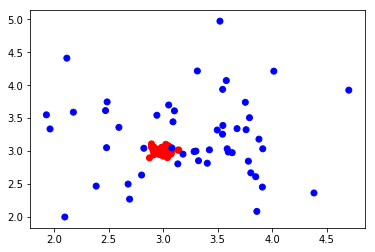

In [225]:
# Datapoints for both classes
N1 = 50
N2 = 50
# K is the number of classes
K = 2
sigma = 0.1
N = N1 + N2

mean = (3,3)
# Covariance matrix with sigma as diagonal
cov = [[0.003, 0], [0, 0.003]]
X1 = np.random.multivariate_normal(mean, cov, N1)
# create list of 'red' for the X1 points
c1 = ['red'] * len(X1)

mean = (3.2,3.2)
# Covariance matrix with sigma as diagonal
cov = [[0.3, 0], [0,0.3]]
X2 = np.random.multivariate_normal(mean,cov,N2)
c2 = ['blue']*len(X2)

# All X datapoints - first 50 are red, next 50 are blue
X = np.concatenate((X1,X2))
color = np.concatenate((c1,c2))

# T here is Nx1 - one for class 1, 0 otherwise
T = 0*np.ones([len(X)])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n] = 0
    if(n>N1 and n<len(X1)+len(X2)):
        T[n] = 1
T = T.astype(int)

# In this case, we want X to be of dimensions 
# ones = np.array([np.ones(X.shape[0])])
# X = np.concatenate((X, np.transpose(ones)), axis = 1)

plt.scatter(X[:,0], X[:,1], marker = 'o', c = color)
plt.show()

9. Classify and show the probability map:

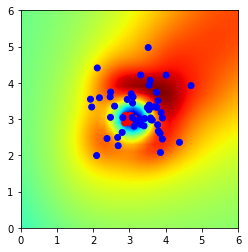

In [227]:
GP_Classification(1,4,1,2)

10. Change the means and clusters back to #1 above, and add another cluster belonging to C2, with mean=[1,1] and sigma=0.1.


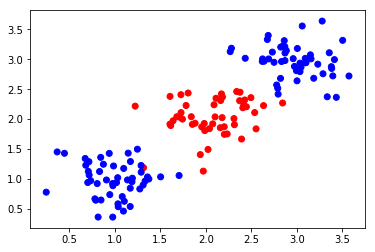

In [229]:
# Datapoints for both classes
N1 = 50
N2 = 50
N3 = 50
# K is the number of classes
K = 2
sigma = 0.1
N = N1 + N2 + N3

mean = (2,2)
# Covariance matrix with sigma as diagonal
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
# create list of 'red' for the X1 points
c1 = ['red'] * len(X1)

mean = (3,3)
# Covariance matrix with sigma as diagonal
cov = [[sigma, 0], [0,sigma]]
X2 = np.random.multivariate_normal(mean,cov,N2)
c2 = ['blue']*len(X2)

mean = (1,1)
# Covariance matrix with sigma as diagonal
cov = [[sigma, 0], [0,sigma]]
X3 = np.random.multivariate_normal(mean,cov,N3)
c3 = ['blue']*len(X3)

# All X datapoints - first 50 are red, next 50 are blue
X = np.concatenate((X1,X2, X3))
color = np.concatenate((c1,c2, c3))

# T here is Nx1 - one for class 1, 0 otherwise
T = 0*np.ones([len(X)])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n] = 0
    if(n>N1 and n<len(X1)+len(X2)+len(X3)):
        T[n] = 1
T = T.astype(int)

# In this case, we want X to be of dimensions 
# ones = np.array([np.ones(X.shape[0])])
# X = np.concatenate((X, np.transpose(ones)), axis = 1)

plt.scatter(X[:,0], X[:,1], marker = 'o', c = color)
plt.show()

11. Classify and show the probability map:

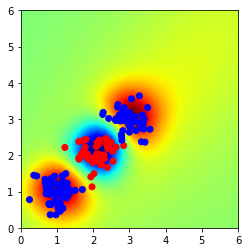

In [230]:
GP_Classification(1,4,1,2)